In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [16]:
# %% create the image
def create_img(k, m, n, step):
    img = np.random.randint(0, step, (k, m,n))
    return img

# %% Finding the min rectangle which warp the triangle
def min_rectangle(r0, r1, r2, theta):
    theta = theta / 180 * np.pi
    x0 = 0
    y0 = 0
    alpha = np.arccos((r2**2 - r1**2 - r0**2) / (2*r0*r1))
    y2 = - r0 * np.cos(theta)
    x2 = r0 * np.sin(theta)
    beta = 2 * np.pi - theta - alpha
    x1 = - r1 * np.sin(beta)
    y1 = - r1 * np.cos(beta)
    return [[x0, y0], [x1, y1], [x2, y2]]

# %% Generate Mask
def generate_mask(x):
    width = np.max((np.abs(x[0,0] - x[1,0]), 
                     np.abs(x[2,0] - x[1,0]),
                     np.abs(x[0,0] - x[2,0])))
    height = np.max((np.abs(x[0,1] - x[1,1]), 
                     np.abs(x[2,1] - x[1,1]),
                     np.abs(x[0,1] - x[2,1])))
    mask = np.zeros([np.int(height)+1, np.int(width)+1])
    ## SHIFT COR
    start_point = np.min(x, axis=0)
    shift_point = x - start_point.reshape([1,2])
    shift_point = np.around(shift_point)
    shift_point = shift_point.astype(np.int)
    mask[shift_point[:,1], shift_point[:,0]] = 1
    return mask

def bilinear(ind, mask_):
    x = ind[0]
    y = ind[1]
    x_0 = np.floor(x)
    y_0 = np.floor(y)
    a = 0
    b = 0
    if x != x_0:
        a = (y - y_0) / (y_0 + 1 - y)
    if y != y_0:
        b = (x - x_0) / (x_0 + 1 - x)
    c = 1 / (a * b + a + b + 1)
    x_0 = x_0.astype(np.int)
    y_0 = y_0.astype(np.int)
    mask_[y_0,x_0] += c
    mask_[y_0,x_0+1] += b * c
    mask_[y_0+1,x_0] += a * c
    mask_[y_0+1,x_0+1] += a * b * c
    return mask_

def generate_bilinear_mask(x):
    ## SHIFT COR
    start_point = np.min(x, axis=0)
    start_point = np.floor(start_point)
    shift_point = x - start_point
    
    width = np.max((np.abs(shift_point[0,0]), 
                     np.abs(shift_point[2,0]),
                     np.abs(shift_point[1,0])))
    height = np.max((np.abs(shift_point[0,1]), 
                     np.abs(shift_point[2,1]),
                     np.abs(shift_point[1,1])))
    mask = np.zeros([(np.ceil(height)+1).astype(np.int), (np.ceil(width)+1).astype(np.int)])
    
    mask[np.int(shift_point[0,1]), np.int(shift_point[0,0])] = 1
    mask = bilinear(shift_point[1,:], mask)
    mask = bilinear(shift_point[2,:], mask)
    return mask

 


In [75]:
def triangle_center(a, b):
    img = np.zeros([a, a])
    k1 = a / 2 * (1 - np.sqrt(3)) + b / (np.sqrt(3))
    k2 = a / 2 * (1 + np.sqrt(3)) + b / (np.sqrt(3))
    for i in range(int(np.round(a / 2 - b / 2)), int(np.ceil(a / 2 + b / 2))):
        for j in range(int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))):
            if(i * np.sqrt(3) + k1 - j >= 0 and i * (-np.sqrt(3)) + k2- j >= 0):
                img[j, i] = 1
    return img

def triangle_filter(a, b):
    img = np.zeros([a, a])
    img[int(np.round(a / 2 - b / 2)), int(np.round(a / 2 - (b / (2 * np.sqrt(3)))))] = 1
    img[int(np.round(a / 2 + b / 2)), int(np.round(a / 2 - (b / (2 * np.sqrt(3)))))] = 1
    img[int(a/2), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))] = 1
#     k1 = a / 2 * (1 - np.sqrt(3)) + b / (np.sqrt(3))
#     k2 = a / 2 * (1 + np.sqrt(3)) + b / (np.sqrt(3))
#     for i in range(int(np.round(a / 2 - b / 2)), int(np.ceil(a / 2 + b / 2))):
#         for j in range(int(np.round(a / 2 - (b / (2 * np.sqrt(3))))), int(np.ceil(a / 2 + (b / (np.sqrt(3)))))):
#             if(i * np.sqrt(3) + k1 - j >= 0 and i * (-np.sqrt(3)) + k2- j >= 0):
#                 img[j, i] = 1
    return img.T

In [20]:
# %% main function
step = 2
size = (10, 10)
n = 30
[x1, x2, x3, x4] = [np.sqrt(2), np.sqrt(2), 2, 45]
a = create_img(n, size[0], size[1], step)
b = min_rectangle(x1, x2, x3, x4)
b = np.asarray(b)
d = generate_mask(b)

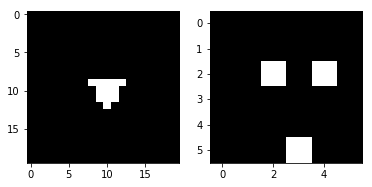

In [121]:
a = triangle_center(20, 5)
size = a.shape
d = triangle_filter(6, 2)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(a, cmap='gray')
axarr[1].imshow(d, cmap='gray')
plt.show()

In [166]:
# %% convert to pytorch code
inputs = torch.from_numpy(a.reshape([1, 1, size[0], size[1]]))
inputs = inputs.type(torch.FloatTensor)
inputs = Variable(inputs)
weights = torch.from_numpy(d.reshape([1,1,d.shape[0], d.shape[1]]))
weights = weights.type(torch.FloatTensor)
weights = Variable(weights)
bias = Variable(torch.tensor([-2.0]))
outputs = F.conv_transpose2d(weights, inputs, bias, padding=0)
outputs = F.sigmoid(outputs)
outputs = torch.mean(outputs, dim=(1,2,3))
outputs = torch.mean(outputs)
print(outputs)

tensor(0.1287)


/Users/cs/anaconda3/envs/py3_ml/lib/python3.5/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [169]:
outputs.requires_grad = False
weights.requires_grad = False
bias.requires_grad = False
I = Variable(torch.rand([1, 1, size[0], size[1]]), requires_grad=True)
init_I = I.detach().data
# I = Variable(I, requires_grad=True)
for i in range(1000):
    out = F.conv_transpose2d(weights, I, bias, padding=0, stride=1)
    out = F.sigmoid(out)
    loss = ((out.mean()-outputs)**2).mean()
    grads = torch.autograd.grad(loss, I)
    print(loss)
    with torch.no_grad():
        if I.grad is None:
            I.grad = grads[0].detach()
        else:
            I.grad.fill_(grads[0].detach())
    I = I - 1000 * I.grad

/Users/cs/anaconda3/envs/py3_ml/lib/python3.5/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(6.2001e-05, grad_fn=<MeanBackward0>)
tensor(3.2605e-05, grad_fn=<MeanBackward0>)
tensor(1.7560e-05, grad_fn=<MeanBackward0>)
tensor(9.6151e-06, grad_fn=<MeanBackward0>)
tensor(5.3271e-06, grad_fn=<MeanBackward0>)
tensor(2.9767e-06, grad_fn=<MeanBackward0>)
tensor(1.6736e-06, grad_fn=<MeanBackward0>)
tensor(9.4531e-07, grad_fn=<MeanBackward0>)
tensor(5.3579e-07, grad_fn=<MeanBackward0>)
tensor(3.0446e-07, grad_fn=<MeanBackward0>)
tensor(1.7334e-07, grad_fn=<MeanBackward0>)
tensor(9.8800e-08, grad_fn=<MeanBackward0>)
tensor(5.6397e-08, grad_fn=<MeanBackward0>)
tensor(3.2215e-08, grad_fn=<MeanBackward0>)
tensor(1.8408e-08, grad_fn=<MeanBackward0>)
tensor(1.0523e-08, grad_fn=<MeanBackward0>)
tensor(6.0226e-09, grad_fn=<MeanBackward0>)
tensor(3.4452e-09, grad_fn=<MeanBackward0>)
tensor(1

tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBack

tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBack

tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBack

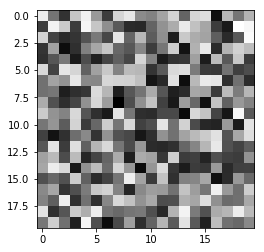

In [168]:
plt.imshow(I.data.numpy()[0,0,:,:], cmap='gray')
plt.show()

In [170]:
F.sigmoid(F.conv_transpose2d(weights, I, bias, padding=0)).mean()

/Users/cs/anaconda3/envs/py3_ml/lib/python3.5/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1287, grad_fn=<MeanBackward0>)

In [172]:
F.sigmoid(F.conv2d(I, weights, bias, padding=9)).mean()

/Users/cs/anaconda3/envs/py3_ml/lib/python3.5/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1247, grad_fn=<MeanBackward0>)

In [173]:
F.sigmoid(F.conv2d(inputs, weights, bias, padding=9)).mean()

/Users/cs/anaconda3/envs/py3_ml/lib/python3.5/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1246)

In [162]:
aa = F.conv_transpose2d(weights, inputs, bias, padding=0).numpy()[0,0,:,:]
bb = F.conv2d(inputs, weights, bias, padding=5).numpy()[0,0,:,:]

In [163]:
np.where(aa >= 1)

(array([], dtype=int64), array([], dtype=int64))

In [164]:
np.where(bb >= 1)

(array([12]), array([12]))

In [165]:
bb

array([[-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
      

In [161]:
aa

array([[-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.],
      